In [1]:
import sys
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import config
import seaborn as sns
import SLM_utils as slm
plt.style.use("bmh")
import figure_utils
from scipy import stats 
from scipy import special
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib import rc
rc('text', usetex=True)
SMALL_SIZE=15
MEDIUM_SIZE=20
rc('legend', fontsize=MEDIUM_SIZE)
rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
rc('ytick', labelsize=SMALL_SIZE)  
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821']

In [2]:
good_species = {}

good_species["am"] = ["Bacteroides_fragilis_54507","Bacteroides_ovatus_58035","Bacteroides_vulgatus_57955",
               "Bacteroides_xylanisolvens_57185","Barnesiella_intestinihominis_62208","Eubacterium_eligens_61678",
               "Eubacterium_rectale_56927"]

good_species["an"] = ["Bacteroides_intestinalis_61596","Bacteroides_ovatus_58035","Bacteroides_uniformis_57318",
                      "Bacteroides_vulgatus_57955","Eubacterium_rectale_56927","Ruminococcus_bicirculans_59300",
                      "Sutterella_wadsworthensis_56828"]

#good_species["ae"] = 

good_species["ao"] = ["Bacteroides_thetaiotaomicron_56941","Bacteroides_xylanisolvens_57185","Bifidobacterium_adolescentis_56815",
                      "Eubacterium_eligens_61678","Eubacterium_rectale_56927","Faecalibacterium_prausnitzii_61481",
                      "Faecalibacterium_prausnitzii_62201"]
max_succ_times = 3


In [3]:
all_freqs = []
for host in good_species.keys():
    for species in good_species[host]:      
        strain_total_freqs,strain_df = slm.calculate_strain_abundances(species, host)
        all_freqs.extend(list(strain_total_freqs.values.flatten()))

In [4]:
beta = np.mean(all_freqs)**2/np.var(all_freqs)

In [5]:
beta

0.45017844983955274

In [8]:
#m2 = np.mean(all_freqs)
m2 = 0
s2 = 1
#s2 = np.std(all_freqs)

In [256]:
rescaled_freqs_dic = {}
for host in good_species.keys():
    rescaled_freqs_dic[host] = {}
    
    for species in good_species[host]:      
        rescaled_freqs_dic[host][species] = []
        strain_total_freqs,strain_df = slm.calculate_strain_abundances(species, host)
        
        for strain in strain_total_freqs:
            
            freqs = np.log10(strain_total_freqs[strain].values)
            
            m1 = np.mean(freqs)
            s1 = np.std(freqs)
            
            rescaled_freqs = m2 + (freqs - m1)*(s2/s1)
            
            rescaled_freqs_dic[host][species].append(rescaled_freqs)

In [257]:
def afd_gamma(x,X_bar,beta):

    return (1/special.gamma(beta))*((beta/X_bar)**beta)*x**(beta-1)*np.exp(-beta*x/X_bar)

In [258]:
xvals = np.linspace(-4 , 3, 10000)

def get_gamma_prediction(x_range, k = 2.4):

    g = (1.13*x_range - 0.9 * 10**(x_range)) + 0.5

    k_digamma = special.digamma(k)
    k_trigamma = special.polygamma(1,k)

    gammalog = k*k_trigamma*x_range - np.exp(np.sqrt(k_trigamma)*x_range + k_digamma) - np.log(special.gamma(k)) + k*k_digamma + np.log10(np.exp(1))

    return gammalog

In [259]:
all_rescaled_freqs = []
for host in good_species.keys():
    for species in good_species[host]: 
        for strain in rescaled_freqs_dic[host][species]:
            all_rescaled_freqs.extend(strain)

In [260]:
all_rescaled_freqs = np.array(all_rescaled_freqs)

In [261]:
lower_lim = .9*min(all_rescaled_freqs)
upper_lim = 1.2*max(all_rescaled_freqs)

logbins = np.logspace(np.log10(lower_lim),np.log10(upper_lim),20)

ab_x = np.logspace(np.log10(lower_lim),np.log10(upper_lim),1000,endpoint=False)

In [16]:
fit_alpha1, fit_loc1, fit_beta1=stats.gamma.fit(10**(all_rescaled_freqs),floc=0)

[]

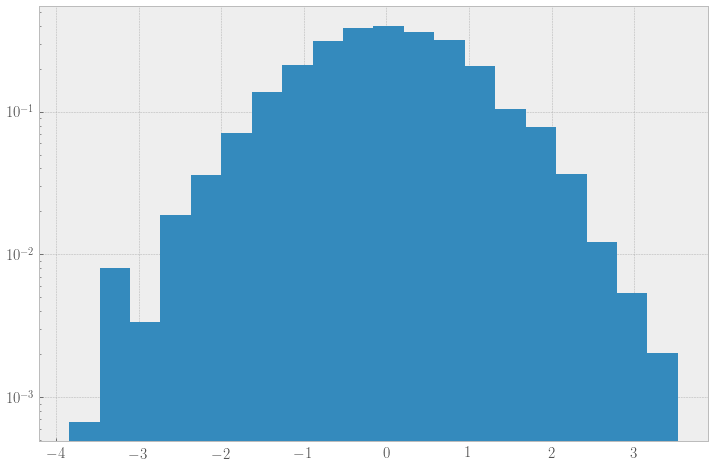

In [262]:
fig, ax = plt.subplots(figsize=(12,8))
h = ax.hist(all_rescaled_freqs,density=True,bins=20)
ax.semilogy()


#ax.plot(ab_x,stats.gamma.pdf(ab_x,fit_alpha1, fit_loc1, fit_beta1),linewidth=5,label="Gamma");
#ax.set_xscale("log");

[]

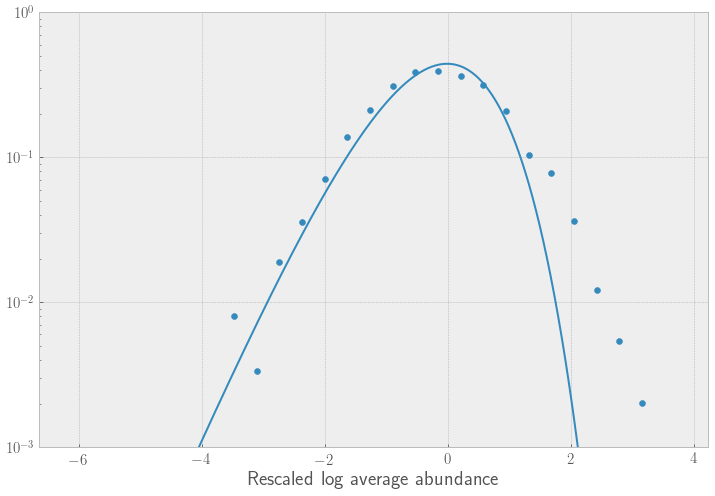

In [263]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(np.sqrt(2)*xvals - .5,10**(get_gamma_prediction(xvals,k=1.5)))

ax.scatter(h[1][:-1],h[0])
#plt.plot(ab_x,stats.gamma.pdf(ab_x,fit_alpha1, fit_loc1, fit_beta1),linewidth=2,label="Gamma",color="k");
#ax.semilogy()
ax.set_ylim([1e-3,1e0])
#ax.set_xlim([-5,5])
ax.set_xlabel("Rescaled log average abundance");
plt.semilogy()

# plt.plot(xvals,afd_gamma(10**(xvals),1,1/beta))
plt.semilogy()
plt.ylim([1e-4,1])

(0.0001, 1)

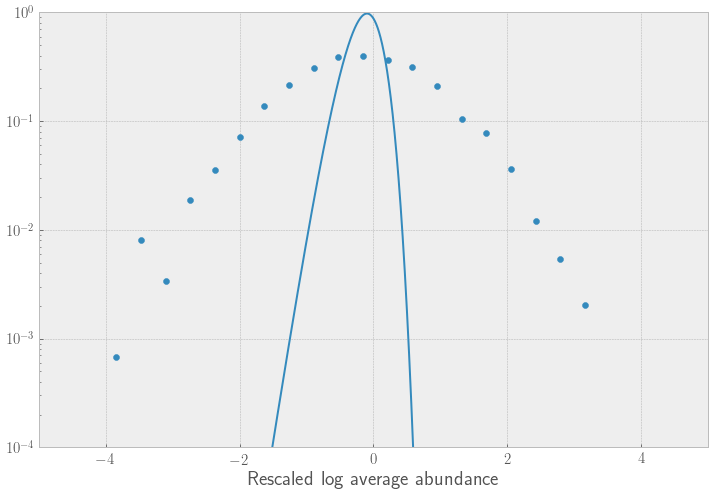

In [98]:
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(h[1][:-1],h[0])
#plt.plot(ab_x,stats.gamma.pdf(ab_x,fit_alpha1, fit_loc1, fit_beta1),linewidth=2,label="Gamma",color="k");
ax.semilogy()
ax.set_ylim([1e-3,1e0])
ax.set_xlim([-5,5])
ax.set_xlabel("Rescaled log average abundance");

plt.plot(xvals,afd_gamma(10**xvals,np.exp(0),5))
plt.semilogy()
plt.ylim([1e-4,1])

In [264]:
X = []
Y = []
for host in good_species.keys():
    for species in good_species[host]: 
        for strain in rescaled_freqs_dic[host][species]:
            count,bins = np.histogram(strain,bins=20,density=True)
            X.append(bins)
            Y.append(count)

Text(0, 0.5, 'Probability density')

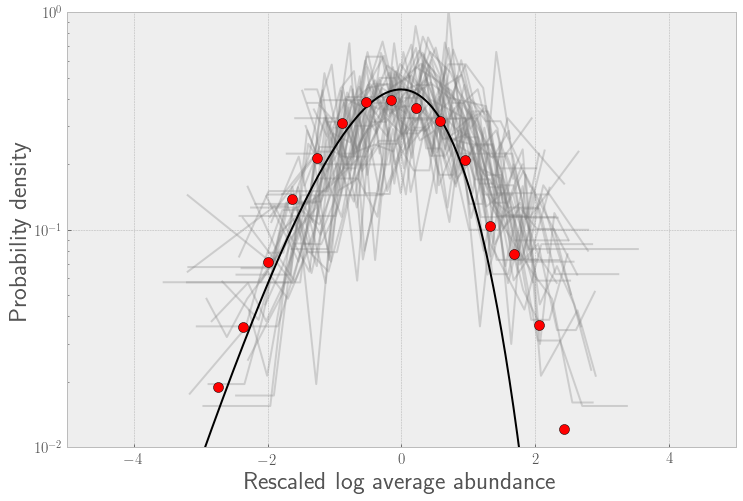

In [265]:
xvals = np.linspace(-4,3,1000) 
fig, ax = plt.subplots(figsize=(12,8))

for i in range(len(X)):
    z= np.argwhere(Y[i] > 0)
    ax.plot(X[i][1:][z],Y[i][z],color="grey",alpha=.3,zorder=1)

ax.scatter(h[1][:-1],h[0],s=100,color="r",edgecolors="k",zorder=3)
ax.semilogy()
ax.set_ylim([1e-3,1e0])
ax.set_xlim([-10,10])
ax.set_xlabel("Rescaled log average abundance",size = 25);

ax.plot(xvals*np.sqrt(2) - .5 ,10**(get_gamma_prediction(xvals,k=1.5)),zorder=2,color="k")
ax.set_xlim([-5,5])
ax.set_ylim([1e-2,1])

ax.set_ylabel("Probability density", size = 25)
#ax.set_ylim([1e-1,3*1e1])
#xvals = np.linspace(-5,1,1000)
#ax.plot(xvals,afd_gamma(np.exp(xvals),1,beta),
 #       linewidth=2,label="Gamma",color="k",alpha=.6);

##### 